<a href="https://colab.research.google.com/github/rul124/Capstone-MSED/blob/main/Hubert_Base_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cpu


In [ ]:
bundle = torchaudio.pipelines.HUBERT_BASE
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/hubert_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/hubert_fairseq_base_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
bundle.sample_rate

16000

### Feature Preparation

In [ ]:
# Define path to datasets
DATA_NATURAL = "/content/drive/MyDrive/MESD/MESD_All"
entries = os.listdir(DATA_NATURAL)
print("First:", entries[0])

First: Anger_C_B_alterado.wav


In [ ]:
sample_file = DATA_NATURAL + "/" + entries[0]
print("Sample file is:", sample_file)
sample_wave, sr = torchaudio.load(sample_file)
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

Sample file is: /content/drive/MyDrive/MESD/MESD_All/Anger_C_B_alterado.wav


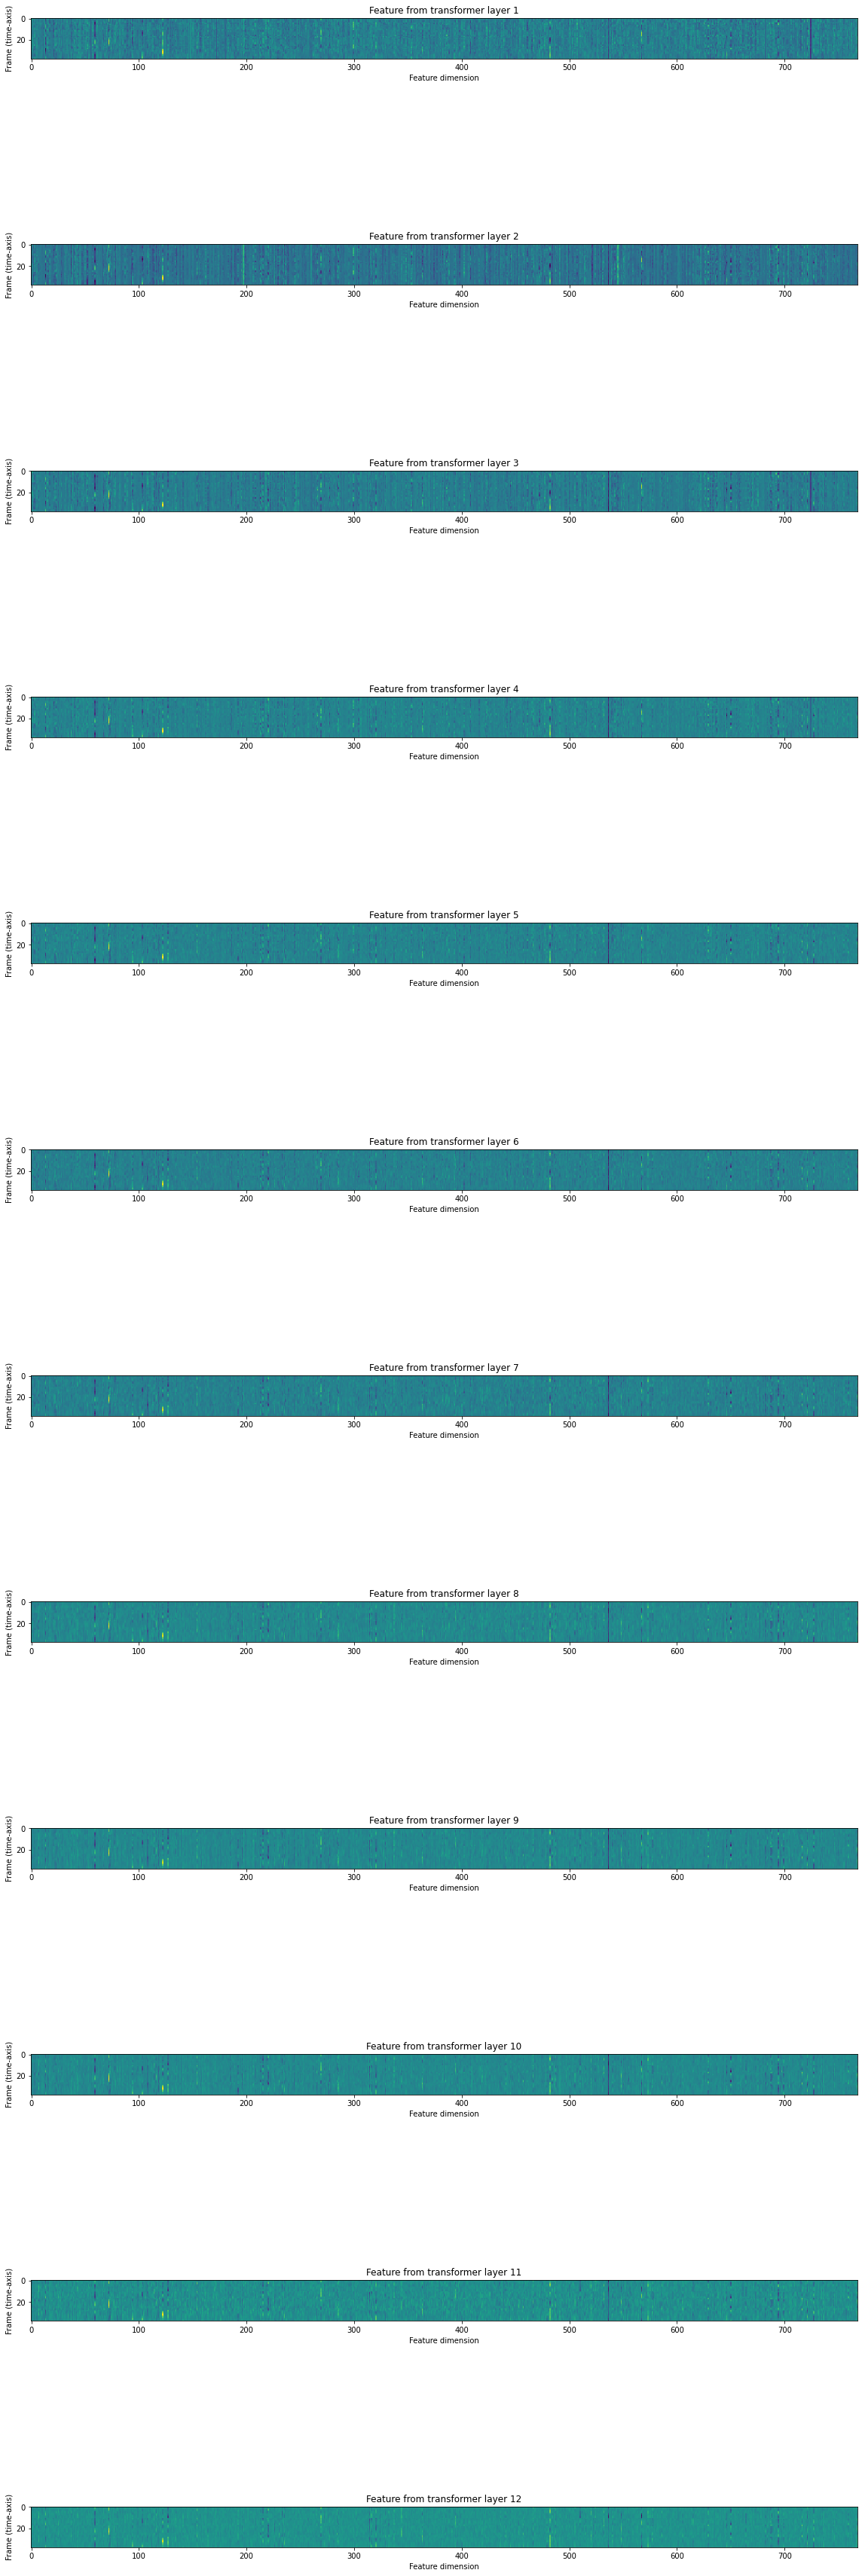

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [ ]:
audios = [[] for i in range(12)]
labels = []

from tqdm import tqdm

for i in tqdm(range(len(entries))):
    entry = entries[i]
    path = DATA_NATURAL + "/" + entry
    if "wav" not in path:
      continue
    label = entry.split("_")[0].lower()
    labels.append(label)
    wave, sr = torchaudio.load(path)
    wave = wave.to(device)
    if sr != bundle.sample_rate:
      wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
      features, _ = model.extract_features(wave)
    for j in range(12):
      audios[j].append(features[j][0])

100%|██████████| 863/863 [03:50<00:00,  3.74it/s]


In [ ]:
columns = {}
columns['Label'] = labels
for i in range(12):
  column_name = "layer_"+str(i+1)
  columns[column_name] = audios[i]
df = pd.DataFrame(columns)
len(df)

862

In [ ]:
df.columns

Index(['Label', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5',
       'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11',
       'layer_12'],
      dtype='object')

In [ ]:
# Save dataframe into a pickle file
DF_PATH = "/content/drive/MyDrive/MESD/hubertbase_features_all.pkl"
# df.to_pickle(DF_PATH)

In [ ]:
# test load pickle file
df = pd.read_pickle(DF_PATH)

In [ ]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [ ]:
categories = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'neutral']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happiness': 3,
 'sadness': 4,
 'neutral': 5}

In [ ]:

def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features, lengths, labels

### Data Visualization -- TSNE

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
len(audios[0])

num_to_cate = {'anger': 'angry',
 'happiness': 'happy',
 'sadness': 'sad',
 'neutral': 'neutral'}

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


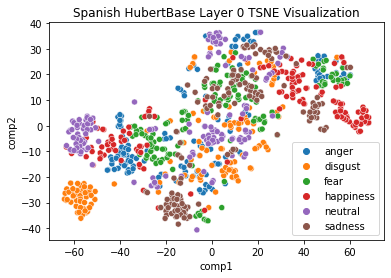

  8%|▊         | 1/12 [00:08<01:28,  8.07s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


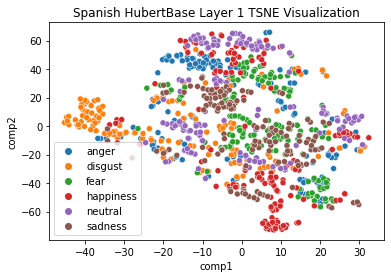

 17%|█▋        | 2/12 [00:13<01:07,  6.79s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


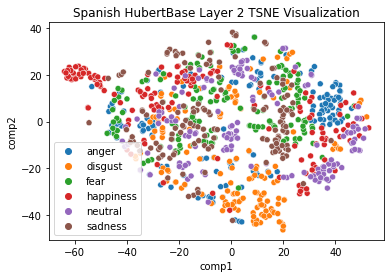

 25%|██▌       | 3/12 [00:19<00:56,  6.32s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


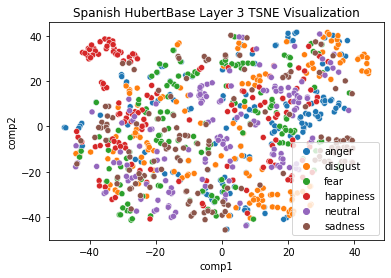

 33%|███▎      | 4/12 [00:25<00:47,  5.98s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


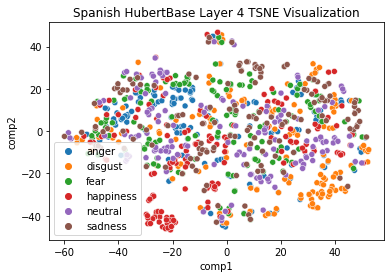

 42%|████▏     | 5/12 [00:30<00:41,  5.91s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


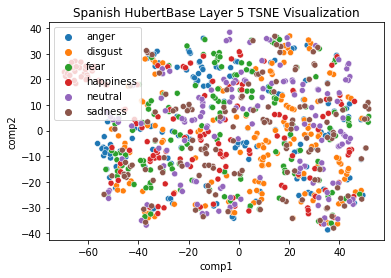

 50%|█████     | 6/12 [00:36<00:35,  5.92s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


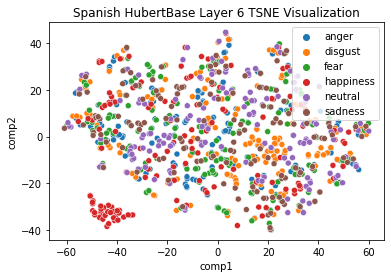

 58%|█████▊    | 7/12 [00:42<00:29,  5.90s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


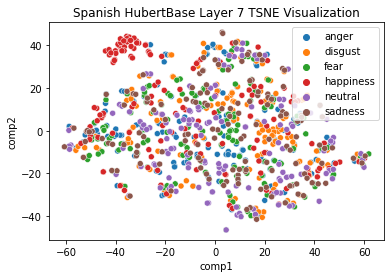

 67%|██████▋   | 8/12 [00:48<00:23,  5.91s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


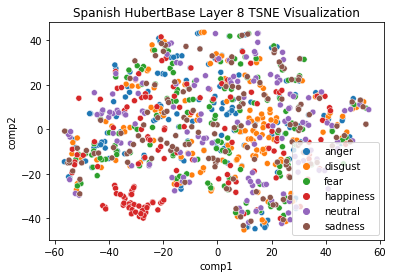

 75%|███████▌  | 9/12 [00:54<00:17,  5.90s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


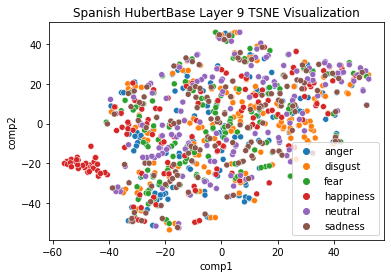

 83%|████████▎ | 10/12 [01:00<00:11,  5.87s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


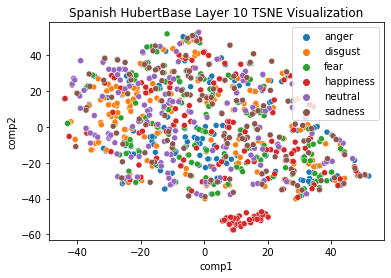

 92%|█████████▏| 11/12 [01:06<00:05,  5.82s/it]/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


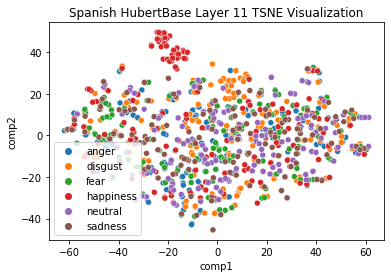

100%|██████████| 12/12 [01:14<00:00,  6.20s/it]


<Figure size 432x288 with 0 Axes>

In [ ]:
labels = list(df['Label'])
for layer in tqdm(range(12)):
  audios_cur = [torch.mean(audio, dim=0).tolist() for audio in audios[layer]]
  cate_audios = []
  cate_labels = []

  for i in range(len(audios_cur)):
    cate_audios.append(audios_cur[i])
    cate_labels.append(labels[i])


  data = pd.DataFrame({'Label':cate_labels, 'Features': cate_audios})
  data = data.sort_values('Label', ignore_index=True)
  tsne = TSNE(n_components=2, random_state=4800, perplexity=20)
  output = tsne.fit_transform(data['Features'].tolist())

  df = pd.DataFrame(output, columns=['comp1', 'comp2'])
  sns.scatterplot(x='comp1', y='comp2', hue=data['Label'].tolist(), data=df)
  plt.title(f'Spanish HubertBase Layer {layer} TSNE Visualization')
  plt.show()
  plt.savefig(f'/content/drive/MyDrive/MESD/tsne_hubertbase_layer_{layer}.png')

## CNN Model Training

### Model Preparation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

### Split Data

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [113]:
layer = 9
print("Length of audios",len(audios[0]))
print("Shape of first:",audios[0][0].shape)
print("Shape of last:",audios[0][-1].shape)

Length of audios 862
Shape of first: torch.Size([38, 768])
Shape of last: torch.Size([43, 768])


In [114]:
X_train, X_test, y_train, y_test = train_test_split(audios[layer], 
                                                    list(df['Label']), 
                                                    test_size=0.2, 
                                                    random_state=4800)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, 
                              collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, 
                             collate_fn=collate_indic)

In [115]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 111, 768])
1 torch.Size([64, 126, 768])
2 torch.Size([64, 108, 768])
3 torch.Size([64, 108, 768])
4 torch.Size([64, 91, 768])
5 torch.Size([64, 66, 768])
6 torch.Size([64, 55, 768])
7 torch.Size([64, 109, 768])
8 torch.Size([64, 88, 768])
9 torch.Size([64, 98, 768])
10 torch.Size([49, 116, 768])


### Model Training

In [116]:
from tqdm import tqdm
from torchsummary import summary
import torch.optim as optim

model = ICASSP3CNN(768)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f},", 
          f"train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f},", 
          f"valid loss:{valid_loss:.2f}")

  3%|▎         | 1/30 [00:39<19:19, 39.97s/it]

epoch:1, train accu:0.2134, train loss:1.88, valid accu:0.2832, valid loss:1.65


  7%|▋         | 2/30 [01:22<19:23, 41.54s/it]

epoch:2, train accu:0.4049, train loss:1.46, valid accu:0.5087, valid loss:1.19


 10%|█         | 3/30 [02:03<18:34, 41.27s/it]

epoch:3, train accu:0.5036, train loss:1.24, valid accu:0.4913, valid loss:1.34


 13%|█▎        | 4/30 [02:44<17:50, 41.16s/it]

epoch:4, train accu:0.5733, train loss:1.09, valid accu:0.4798, valid loss:1.31


 17%|█▋        | 5/30 [03:27<17:22, 41.71s/it]

epoch:5, train accu:0.6444, train loss:0.91, valid accu:0.4913, valid loss:1.34


 20%|██        | 6/30 [04:09<16:43, 41.79s/it]

epoch:6, train accu:0.7054, train loss:0.81, valid accu:0.6069, valid loss:1.11


 23%|██▎       | 7/30 [04:54<16:25, 42.84s/it]

epoch:7, train accu:0.7808, train loss:0.61, valid accu:0.5145, valid loss:1.25


 27%|██▋       | 8/30 [05:35<15:31, 42.32s/it]

epoch:8, train accu:0.8287, train loss:0.51, valid accu:0.5434, valid loss:1.41


 30%|███       | 9/30 [06:17<14:44, 42.10s/it]

epoch:9, train accu:0.8273, train loss:0.49, valid accu:0.5434, valid loss:1.40


 33%|███▎      | 10/30 [07:00<14:09, 42.47s/it]

epoch:10, train accu:0.8636, train loss:0.38, valid accu:0.5607, valid loss:1.55


 37%|███▋      | 11/30 [07:41<13:19, 42.09s/it]

epoch:11, train accu:0.8999, train loss:0.30, valid accu:0.5491, valid loss:1.72


 40%|████      | 12/30 [08:22<12:34, 41.89s/it]

epoch:12, train accu:0.9419, train loss:0.19, valid accu:0.6012, valid loss:1.53


 43%|████▎     | 13/30 [09:03<11:45, 41.49s/it]

epoch:13, train accu:0.9347, train loss:0.21, valid accu:0.6012, valid loss:1.64


 47%|████▋     | 14/30 [09:47<11:14, 42.14s/it]

epoch:14, train accu:0.9390, train loss:0.19, valid accu:0.5838, valid loss:1.62


 50%|█████     | 15/30 [10:39<11:19, 45.32s/it]

epoch:15, train accu:0.9245, train loss:0.22, valid accu:0.5665, valid loss:1.96


 53%|█████▎    | 16/30 [11:25<10:35, 45.43s/it]

epoch:16, train accu:0.9144, train loss:0.25, valid accu:0.5260, valid loss:1.81


 57%|█████▋    | 17/30 [12:08<09:41, 44.72s/it]

epoch:17, train accu:0.9245, train loss:0.27, valid accu:0.5145, valid loss:1.97


 60%|██████    | 18/30 [12:48<08:38, 43.22s/it]

epoch:18, train accu:0.9347, train loss:0.22, valid accu:0.5260, valid loss:1.74


 63%|██████▎   | 19/30 [13:29<07:48, 42.59s/it]

epoch:19, train accu:0.9550, train loss:0.15, valid accu:0.5607, valid loss:1.67


 67%|██████▋   | 20/30 [14:12<07:08, 42.83s/it]

epoch:20, train accu:0.9782, train loss:0.07, valid accu:0.5838, valid loss:2.00


 70%|███████   | 21/30 [14:53<06:20, 42.24s/it]

epoch:21, train accu:0.9855, train loss:0.04, valid accu:0.5376, valid loss:2.52


 73%|███████▎  | 22/30 [15:35<05:37, 42.21s/it]

epoch:22, train accu:0.9492, train loss:0.20, valid accu:0.5029, valid loss:2.64


 77%|███████▋  | 23/30 [16:17<04:53, 41.92s/it]

epoch:23, train accu:0.8824, train loss:0.40, valid accu:0.5202, valid loss:1.77


 80%|████████  | 24/30 [16:57<04:08, 41.41s/it]

epoch:24, train accu:0.9086, train loss:0.29, valid accu:0.5318, valid loss:1.62


 83%|████████▎ | 25/30 [17:39<03:27, 41.49s/it]

epoch:25, train accu:0.9579, train loss:0.14, valid accu:0.5260, valid loss:1.74


 87%|████████▋ | 26/30 [18:21<02:46, 41.69s/it]

epoch:26, train accu:0.9855, train loss:0.05, valid accu:0.5780, valid loss:2.11


 90%|█████████ | 27/30 [19:05<02:07, 42.43s/it]

epoch:27, train accu:0.9811, train loss:0.04, valid accu:0.5838, valid loss:2.16


 93%|█████████▎| 28/30 [19:47<01:24, 42.24s/it]

epoch:28, train accu:0.9927, train loss:0.02, valid accu:0.5318, valid loss:2.36


 97%|█████████▋| 29/30 [20:28<00:41, 42.00s/it]

epoch:29, train accu:0.9927, train loss:0.03, valid accu:0.5607, valid loss:2.35


100%|██████████| 30/30 [21:11<00:00, 42.39s/it]

epoch:30, train accu:0.9956, train loss:0.02, valid accu:0.5029, valid loss:2.67


In [117]:
model_path = f'/content/drive/MyDrive/MESD/models/hubert_base_{layer}.pth'

torch.save({'epoch':epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path)

metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 
                         'valid loss':valid_losses, 'train accu':train_accuracies, 
                         'valid_accu':valid_accuracies})
metadata.to_csv(f'/content/drive/MyDrive/MESD/results/hubertbase_{layer}.csv ', 
                index=False)

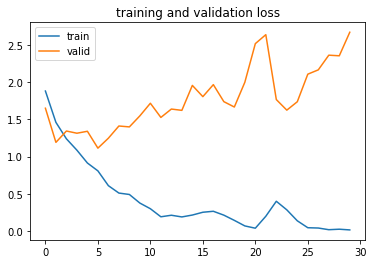

In [118]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

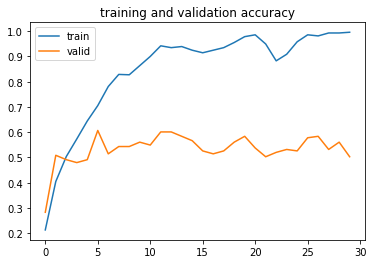

In [119]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [120]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

for inputs, lengths, labels in test_dataloader:
    output = model(inputs, lengths) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

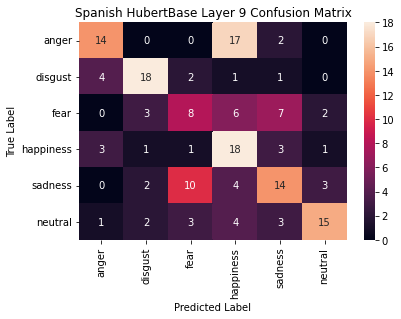

In [121]:
import numpy as np
cf = confusion_matrix(y_true, y_pred)
df = pd.read_pickle(DF_PATH)
classes = list(df['Label'].unique())
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                     columns = [i for i in classes])
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Spanish HubertBase Layer {layer} Confusion Matrix')
plt.savefig(f'/content/drive/MyDrive/MESD/results/confusion_hubertbase_{layer}.png')